# arXiv Classification with Spark NLP

This notebook demonstrates text classification on arXiv paper abstracts using two approaches:
1. **TF-IDF + Logistic Regression** - Traditional ML approach
2. **DistilBERT + ClassifierDL** - Deep learning approach with Spark NLP

---

## 1. Setup & Installation

In [1]:
# # Clean install of PySpark and Spark NLP
# !pip uninstall pyspark spark-nlp -y
# !rm -rf ~/.ivy2/jars/*
# !rm -rf ~/.ivy2/cache/com.johnsnowlabs.nlp/
# !pip cache purge

# !pip install --no-cache-dir pyspark==3.5.0
# !pip install --no-cache-dir spark-nlp==5.5.0

# # Additional dependencies
# !pip install --upgrade pip
# !pip install pandas matplotlib seaborn numpy scikit-learn
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers datasets accelerate>=0.26.0

In [2]:
## 2. Imports & Configuration

In [3]:
# Standard libraries
import json
import sys
import warnings
from collections import Counter, defaultdict
from datetime import datetime

# Data science
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode, count, expr
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Spark NLP
import sparknlp
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import (
    Tokenizer as SparkNLPTokenizer,
    DistilBertEmbeddings,
    ClassifierDLApproach,
    SentenceEmbeddings
)

# Configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Version check
print(f"Python version: {sys.version}")
print(f"PySpark version: {pyspark.__version__}")
print(f"Spark NLP version: {sparknlp.version()}")

Python version: 3.10.12 (main, Jan  8 2026, 06:52:19) [GCC 11.4.0]
PySpark version: 3.5.0
Spark NLP version: 5.5.0


## 3. Initialize Spark Session

In [4]:
# Initialize Spark with Spark NLP
spark = sparknlp.start(gpu=False, memory="8G")
spark.sparkContext.setLogLevel("WARN")

print(f"Spark runtime version: {spark.version}")

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-91761fa1-8992-42a4-98b4-d73a298af007;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.5.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in centra

Spark runtime version: 3.5.0


## 4. Load & Explore Data

In [5]:
# Load arXiv metadata
df = spark.read.json("arxiv-metadata-oai-snapshot.json")

# Preview categories
df.select("categories").show(5, truncate=False)

# Count unique category combinations
unique_count = df.select("categories").distinct().count()
print(f"Unique category combinations: {unique_count}")

+---------------+
|categories     |
+---------------+
|hep-ph         |
|math.CO cs.CG  |
|physics.gen-ph |
|math.CO        |
|math.CA math.FA|
+---------------+
only showing top 5 rows



[Stage 2:===============================================>           (4 + 1) / 5]

Unique category combinations: 21564


In [6]:
# Top 20 category combinations
top_categories = df.groupBy("categories") \
                   .agg(count("*").alias("count")) \
                   .orderBy(col("count").desc()) \
                   .limit(20)
top_categories.show(truncate=False)

# Explode categories to see individual labels
df_exploded = df.withColumn("category", explode(split(col("categories"), " ")))
unique_exploded = df_exploded.select("category").distinct().count()
print(f"Unique individual categories: {unique_exploded}")

+-----------------+-----+
|categories       |count|
+-----------------+-----+
|astro-ph         |16405|
|hep-ph           |15547|
|quant-ph         |13733|
|astro-ph.CO      |10718|
|hep-th           |10424|
|astro-ph.SR      |8477 |
|cond-mat.mes-hall|7550 |
|cond-mat.mtrl-sci|7041 |
|gr-qc            |5777 |
|cond-mat.str-el  |5552 |
|cs.IT math.IT    |5204 |
|math.PR          |5149 |
|math.AP          |4916 |
|astro-ph.HE      |4872 |
|math.CO          |4792 |
|hep-ex           |4778 |
|math.AG          |4211 |
|nucl-th          |4110 |
|cond-mat.supr-con|4026 |
|astro-ph.GA      |3981 |
+-----------------+-----+



[Stage 11:==================================>                       (3 + 2) / 5]

Unique individual categories: 155


## 5. Data Preparation

In [7]:
# Use primary category (first in list) as label
df_ml = df.select("abstract", "categories") \
          .withColumn("label", split(col("categories"), " ").getItem(0)) \
          .select("abstract", "label") \
          .na.drop()

df_ml.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-

In [8]:
# Filter to top N categories and limit dataset size
TOP_N = 10
SAMPLE_SIZE = 20000

top_labels = (
    df_ml.groupBy("label")
         .agg(count("*").alias("count"))
         .orderBy(col("count").desc())
         .limit(TOP_N)
         .select("label")
)

df_ml = df_ml.join(top_labels, on="label", how="inner").limit(SAMPLE_SIZE)

# Show unique labels
print(f"Selected {TOP_N} categories:")
df_ml.select("label").distinct().show(truncate=False)

Selected 10 categories:


[Stage 21:==============================================>           (4 + 1) / 5]

+-----------------+
|label            |
+-----------------+
|hep-ph           |
|cond-mat.mes-hall|
|gr-qc            |
|cond-mat.mtrl-sci|
|astro-ph         |
|hep-th           |
|cond-mat.str-el  |
|quant-ph         |
+-----------------+



---

## 6. Approach 1: TF-IDF + Logistic Regression

Traditional ML approach using term frequency-inverse document frequency features.

In [9]:
# Build TF-IDF + Logistic Regression Pipeline
label_indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=20000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="labelIndex", maxIter=20)

tfidf_pipeline = Pipeline(stages=[
    label_indexer,
    tokenizer,
    remover,
    hashingTF,
    idf,
    lr
])

In [10]:
# Train/test split and model training
train, test = df_ml.randomSplit([0.8, 0.2], seed=42)

tfidf_model = tfidf_pipeline.fit(train)
tfidf_model.write().overwrite().save("models/logreg_text_classifier")

predictions = tfidf_model.transform(test)
predictions.select("abstract", "label", "prediction").show(5, truncate=False)

26/01/15 13:04:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/01/15 13:04:56 WARN TaskSetManager: Stage 107 contains a task of very large size (1297 KiB). The maximum recommended task size is 1000 KiB.
[Stage 113:==================================>                      (3 + 2) / 5]

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

26/01/15 13:05:00 WARN DAGScheduler: Broadcasting large task binary with size 1660.8 KiB
                                                                                

In [11]:
# Evaluate TF-IDF model
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="f1"
)

accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"TF-IDF + LogReg Results:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Score: {f1_score:.4f}")

26/01/15 13:05:03 WARN DAGScheduler: Broadcasting large task binary with size 1716.2 KiB
26/01/15 13:05:08 WARN DAGScheduler: Broadcasting large task binary with size 1716.2 KiB


TF-IDF + LogReg Results:
  Accuracy: 0.7898
  F1 Score: 0.7921


In [12]:
# Confusion matrix
confusion = predictions.groupBy("labelIndex", "prediction") \
    .count() \
    .orderBy("labelIndex", "prediction")
confusion.show(50)

# Label mapping
labels = tfidf_model.stages[0].labels
print("\nLabel Index Mapping:")
for i, label in enumerate(labels):
    print(f"  {i}: {label}")

26/01/15 13:05:11 WARN DAGScheduler: Broadcasting large task binary with size 1683.4 KiB
                                                                                

+----------+----------+-----+
|labelIndex|prediction|count|
+----------+----------+-----+
|       0.0|       0.0| 1241|
|       0.0|       1.0|   45|
|       0.0|       2.0|   24|
|       0.0|       3.0|   16|
|       0.0|       4.0|   60|
|       0.0|       5.0|    7|
|       0.0|       6.0|   11|
|       0.0|       7.0|    9|
|       1.0|       0.0|   23|
|       1.0|       1.0|  493|
|       1.0|       2.0|   49|
|       1.0|       3.0|    8|
|       1.0|       4.0|    7|
|       1.0|       6.0|    5|
|       1.0|       7.0|    2|
|       2.0|       0.0|    6|
|       2.0|       1.0|   41|
|       2.0|       2.0|  383|
|       2.0|       3.0|   18|
|       2.0|       4.0|   51|
|       2.0|       5.0|    4|
|       2.0|       6.0|    2|
|       2.0|       7.0|    2|
|       3.0|       0.0|    3|
|       3.0|       1.0|    7|
|       3.0|       2.0|   20|
|       3.0|       3.0|  355|
|       3.0|       4.0|    8|
|       3.0|       5.0|   12|
|       3.0|       6.0|   25|
|       3.

In [13]:
# Example prediction
example = predictions.select("abstract", "label", "prediction").limit(1).collect()[0]

true_label = example["label"]
pred_index = int(example["prediction"])
pred_label = labels[pred_index]

print("ABSTRACT:")
print(example["abstract"][:500], "...")
print(f"\nTRUE CATEGORY: {true_label}")
print(f"PREDICTED CATEGORY: {pred_label}")

26/01/15 13:05:16 WARN DAGScheduler: Broadcasting large task binary with size 1659.9 KiB
                                                                                

ABSTRACT:
  $UBVRI$ photometry and medium resolution optical spectroscopy of peculiar
Type Ia supernova SN 2005hk are presented and analysed, covering the
pre-maximum phase to around 400 days after explosion. The supernova is found to
be underluminous compared to "normal" Type Ia supernovae. The photometric and
spectroscopic evolution of SN 2005hk is remarkably similar to the peculiar Type
Ia event SN 2002cx. The expansion velocity of the supernova ejecta is found to
be lower than normal Type Ia events. T ...

TRUE CATEGORY: astro-ph
PREDICTED CATEGORY: astro-ph


---

## 7. Approach 2: DistilBERT + ClassifierDL

Deep learning approach using pre-trained DistilBERT embeddings with Spark NLP.

In [37]:
# Prepare data for DistilBERT with BALANCED sampling
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rand

BERT_TOP_N = 10
SAMPLES_PER_CATEGORY = 200  # 200 per category = 2000 total
BERT_SAMPLE_SIZE = 2000

df_bert = df.select("abstract", "categories") \
            .withColumn("label", split(col("categories"), " ").getItem(0)) \
            .select(col("abstract").alias("text"), "label") \
            .na.drop()

bert_top_labels = (
    df_bert.groupBy("label")
           .agg(count("*").alias("count"))
           .orderBy(col("count").desc())
           .limit(BERT_TOP_N)
           .select("label")
)

df_bert.groupBy("label").count().orderBy("label").show()

# Join with top labels firstprint("DistilBERT - Samples per category:")

# df_bert = df_bert.join(bert_top_labels, on="label", how="inner")# Verify balanced distribution

df_bert = df_bert.join(bert_top_labels, on="label", how="inner").limit(BERT_SAMPLE_SIZE)
# Balanced sampling: take exactly SAMPLES_PER_CATEGORY from each categorytrain_bert, test_bert = df_bert.randomSplit([0.8, 0.2], seed=42)

# window = Window.partitionBy("label").orderBy(rand(seed=42))

# df_bert = df_bert.withColumn("row_num", row_number().over(window)).drop("row_num").filter(col("row_num") <= SAMPLES_PER_CATEGORY)

train_bert, test_bert = df_bert.randomSplit([0.8, 0.2], seed=42)

[Stage 424:==================================>                      (3 + 2) / 5]

+------------------+-----+
|             label|count|
+------------------+-----+
|          astro-ph|17812|
|       astro-ph.CO|16487|
|       astro-ph.EP| 3652|
|       astro-ph.GA| 6065|
|       astro-ph.HE| 7926|
|       astro-ph.IM| 3350|
|       astro-ph.SR|11292|
|   cond-mat.dis-nn| 2165|
| cond-mat.mes-hall|13641|
| cond-mat.mtrl-sci|11209|
|    cond-mat.other| 2738|
|cond-mat.quant-gas| 3525|
|     cond-mat.soft| 4989|
|cond-mat.stat-mech| 8414|
|   cond-mat.str-el|10172|
| cond-mat.supr-con| 7841|
|             cs.AI| 2462|
|             cs.AR|  261|
|             cs.CC| 1075|
|             cs.CE|  341|
+------------------+-----+
only showing top 20 rows



In [38]:
# Build DistilBERT Pipeline
document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer_bert = SparkNLPTokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

distilbert = DistilBertEmbeddings.pretrained("distilbert_base_uncased", "en") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("embeddings")

sentence_embeddings = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

classifier = ClassifierDLApproach() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("prediction") \
    .setLabelColumn("label") \
    .setBatchSize(16) \
    .setMaxEpochs(5) \
    .setLr(1e-3) \
    .setEnableOutputLogs(True)

bert_pipeline = Pipeline(stages=[
    document,
    tokenizer_bert,
    distilbert,
    sentence_embeddings,
    classifier
])

distilbert_base_uncased download started this may take some time.


26/01/15 13:57:45 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 235.8 MB
[OK!]


In [39]:
# Train DistilBERT model
bert_model = bert_pipeline.fit(train_bert)
bert_model.write().overwrite().save("models/distilbert_classifier")

bert_predictions = bert_model.transform(test_bert)
bert_predictions.select(
    col("text"),
    col("label"),
    col("prediction.result")[0].alias("predicted_label")
).show(5, truncate=80)

2026-01-15 14:04:39.988400: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/bb97d05ed294_classifier_dl17814946230722452315
2026-01-15 14:04:40.055567: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2026-01-15 14:04:40.055733: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/bb97d05ed294_classifier_dl17814946230722452315
2026-01-15 14:04:40.476304: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2026-01-15 14:04:41.181530: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/bb97d05ed294_classifier_dl17814946230722452315
2026-01-15 14:04:41.323378: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1335053 microse

Training started - epochs: 5 - learning_rate: 0.001 - batch_size: 16 - training_examples: 1642 - classes: 8
Epoch 1/5 - 0.68s - loss: 188.03795 - acc: 0.4702206 - batches: 103
Epoch 2/5 - 0.38s - loss: 179.49506 - acc: 0.5441176 - batches: 103
Epoch 3/5 - 0.41s - loss: 178.42267 - acc: 0.56188726 - batches: 103
Epoch 4/5 - 0.39s - loss: 177.85081 - acc: 0.5675245 - batches: 103
Epoch 5/5 - 0.41s - loss: 177.45416 - acc: 0.5969363 - batches: 103


[Stage 459:>                                                        (0 + 1) / 1]

+--------------------------------------------------------------------------------+--------+---------------+
|                                                                            text|   label|predicted_label|
+--------------------------------------------------------------------------------+--------+---------------+
|  (Abridged) Luminous Compact Galaxies (LCGs) (M_B < -20, R_{1/2} < 4.5kpc an...|astro-ph|       astro-ph|
|  (abridged) The soft excess seen in the X-ray spectra of many high mass\nacc...|astro-ph|       astro-ph|
|  A SST survey in the NOAO Deep-Wide Field in Bo\"otes provides a complete,\n...|astro-ph|       astro-ph|
|  A few FRI radio galaxies were detected at GeV gamma-rays with CGRO EGRET,\n...|astro-ph|       astro-ph|
|  A new inflationary scenario whose exponential potential $V(\Phi)$ has a\nqu...|astro-ph|         hep-ph|
+--------------------------------------------------------------------------------+--------+---------------+
only showing top 5 rows



In [40]:
# Evaluate DistilBERT model
# Extract predicted label from Spark NLP annotation
bert_predictions_eval = bert_predictions.withColumn(
    "predicted_label",
    expr("prediction.result[0]")
)

# Convert string labels to numeric indices for evaluation
label_indexer_eval = StringIndexer(inputCol="label", outputCol="label_index")
pred_indexer_eval = StringIndexer(inputCol="predicted_label", outputCol="predicted_index")

# Fit on true labels and transform both columns
label_indexer_model = label_indexer_eval.fit(bert_predictions_eval)
bert_predictions_indexed = label_indexer_model.transform(bert_predictions_eval)

pred_indexer_model = pred_indexer_eval.fit(bert_predictions_indexed)
bert_predictions_indexed = pred_indexer_model.transform(bert_predictions_indexed)

# Now evaluate with numeric columns
bert_evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="predicted_index", metricName="accuracy"
)
bert_evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="predicted_index", metricName="f1"
)

bert_accuracy = bert_evaluator_acc.evaluate(bert_predictions_indexed)
bert_f1 = bert_evaluator_f1.evaluate(bert_predictions_indexed)

print(f"DistilBERT + ClassifierDL Results:")
print(f"  Accuracy: {bert_accuracy:.4f}")
print(f"  F1 Score: {bert_f1:.4f}")

[Stage 484:>                                                        (0 + 1) / 1]

DistilBERT + ClassifierDL Results:
  Accuracy: 0.4358
  F1 Score: 0.3710


---

## 8. Approach 3: SciBERT + ClassifierDL

Deep learning approach using SciBERT embeddings - a BERT model pre-trained on scientific text (Semantic Scholar corpus), making it particularly suited for arXiv classification.

In [29]:
# Import BertEmbeddings for SciBERT
from sparknlp.annotator import BertEmbeddings

# Prepare data for SciBERT with BALANCED sampling
SCIBERT_TOP_N = 10
SCIBERT_SAMPLES_PER_CATEGORY = 200  # 200 per category = 2000 total
SCIBERT_SAMPLES = 2000

df_scibert = df.select("abstract", "categories") \
               .withColumn("label", split(col("categories"), " ").getItem(0)) \
               .select(col("abstract").alias("text"), "label") \
               .na.drop()

scibert_top_labels = (
    df_scibert.groupBy("label")
              .agg(count("*").alias("count"))
              .orderBy(col("count").desc())
              .limit(SCIBERT_TOP_N)
              .select("label")
)

# Join with top labels first
# df_scibert = df_scibert.join(scibert_top_labels, on="label", how="inner")
df_scibert = df_scibert.join(scibert_top_labels, on="label", how="inner").limit(SCIBERT_SAMPLES)
# Balanced sampling: take exactly SAMPLES_PER_CATEGORY from each category
# window_sci = Window.partitionBy("label").orderBy(rand(seed=42))

# df_scibert = df_scibert.withColumn("row_num", row_number().over(window_sci)).filter(col("row_num") <= SCIBERT_SAMPLES_PER_CATEGORY).drop("row_num")
df_scibert.groupBy("label").count().orderBy("label").show()

print("SciBERT - Samples per category:")

train_scibert, test_scibert = df_scibert.randomSplit([0.8, 0.2], seed=42)# Verify balanced distribution
print(f"SciBERT test samples: {test_scibert.count()}")
print(f"SciBERT training samples: {train_scibert.count()}")


+-----------------+-----+
|            label|count|
+-----------------+-----+
|         astro-ph|  794|
|cond-mat.mes-hall|  120|
|cond-mat.mtrl-sci|  133|
|  cond-mat.str-el|  123|
|            gr-qc|  130|
|           hep-ph|  245|
|           hep-th|  243|
|         quant-ph|  212|
+-----------------+-----+

SciBERT - Samples per category:


SciBERT test samples: 358


SciBERT training samples: 1642


In [30]:
# Build SciBERT Pipeline
# Note: Using bert_base_uncased as scibert_scivocab_uncased is not available in Spark NLP hub
# Alternative scientific models: biobert_pubmed_base_cased (for biomedical)

document_scibert = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer_scibert = SparkNLPTokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Option 1: Use standard BERT (most reliable)
scibert = BertEmbeddings.pretrained("bert_base_uncased", "en") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("embeddings")

sentence_embeddings_scibert = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

classifier_scibert = ClassifierDLApproach() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("prediction") \
    .setLabelColumn("label") \
    .setBatchSize(16) \
    .setMaxEpochs(5) \
    .setLr(1e-3) \
    .setEnableOutputLogs(True)

scibert_pipeline = Pipeline(stages=[
    document_scibert,
    tokenizer_scibert,
    scibert,
    sentence_embeddings_scibert,
    classifier_scibert
])

bert_base_uncased download started this may take some time.


26/01/15 13:37:51 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 392.5 MB
[OK!]


In [31]:
# Train SciBERT model
scibert_model = scibert_pipeline.fit(train_scibert)
scibert_model.write().overwrite().save("models/scibert_classifier")

scibert_predictions = scibert_model.transform(test_scibert)
scibert_predictions.select(
    col("text"),
    col("label"),
    col("prediction.result")[0].alias("predicted_label")
).show(5, truncate=80)

2026-01-15 13:45:45.890898: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/9457d25df292_classifier_dl6663835888477793566
2026-01-15 13:45:45.963614: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2026-01-15 13:45:45.963668: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/9457d25df292_classifier_dl6663835888477793566
2026-01-15 13:45:46.402310: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2026-01-15 13:45:47.134261: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/9457d25df292_classifier_dl6663835888477793566
2026-01-15 13:45:47.290783: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 1399950 microsecon

Training started - epochs: 5 - learning_rate: 0.001 - batch_size: 16 - training_examples: 1642 - classes: 8
Epoch 1/5 - 0.69s - loss: 189.67822 - acc: 0.49865195 - batches: 103
Epoch 2/5 - 0.39s - loss: 187.11815 - acc: 0.5115196 - batches: 103
Epoch 3/5 - 0.39s - loss: 187.2774 - acc: 0.517647 - batches: 103
Epoch 4/5 - 0.47s - loss: 187.2849 - acc: 0.5182598 - batches: 103
Epoch 5/5 - 0.41s - loss: 187.18286 - acc: 0.5182598 - batches: 103


[Stage 362:>                                                        (0 + 1) / 1]

+--------------------------------------------------------------------------------+--------+---------------+
|                                                                            text|   label|predicted_label|
+--------------------------------------------------------------------------------+--------+---------------+
|  (Abridged) Luminous Compact Galaxies (LCGs) (M_B < -20, R_{1/2} < 4.5kpc an...|astro-ph|       astro-ph|
|  (abridged) The soft excess seen in the X-ray spectra of many high mass\nacc...|astro-ph|       astro-ph|
|  A SST survey in the NOAO Deep-Wide Field in Bo\"otes provides a complete,\n...|astro-ph|       astro-ph|
|  A few FRI radio galaxies were detected at GeV gamma-rays with CGRO EGRET,\n...|astro-ph|       astro-ph|
|  A new inflationary scenario whose exponential potential $V(\Phi)$ has a\nqu...|astro-ph|       astro-ph|
+--------------------------------------------------------------------------------+--------+---------------+
only showing top 5 rows



In [32]:
# Evaluate SciBERT model
# Extract predicted label from Spark NLP annotation
scibert_predictions_eval = scibert_predictions.withColumn(
    "predicted_label",
    expr("prediction.result[0]")
)

# Convert string labels to numeric indices for evaluation
label_indexer_scibert = StringIndexer(inputCol="label", outputCol="label_index")
pred_indexer_scibert = StringIndexer(inputCol="predicted_label", outputCol="predicted_index")

# Fit and transform
label_indexer_scibert_model = label_indexer_scibert.fit(scibert_predictions_eval)
scibert_predictions_indexed = label_indexer_scibert_model.transform(scibert_predictions_eval)

pred_indexer_scibert_model = pred_indexer_scibert.fit(scibert_predictions_indexed)
scibert_predictions_indexed = pred_indexer_scibert_model.transform(scibert_predictions_indexed)

# Evaluate with numeric columns
scibert_evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="predicted_index", metricName="accuracy"
)
scibert_evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="predicted_index", metricName="f1"
)

scibert_accuracy = scibert_evaluator_acc.evaluate(scibert_predictions_indexed)
scibert_f1 = scibert_evaluator_f1.evaluate(scibert_predictions_indexed)

print(f"SciBERT + ClassifierDL Results:")
print(f"  Accuracy: {scibert_accuracy:.4f}")
print(f"  F1 Score: {scibert_f1:.4f}")

[Stage 387:>                                                        (0 + 1) / 1]

SciBERT + ClassifierDL Results:
  Accuracy: 0.4637
  F1 Score: 0.3184


---

## 9. Model Comparison Summary

MODEL COMPARISON SUMMARY

Model                          Accuracy     F1 Score    
------------------------------------------------------
TF-IDF + Logistic Regression   0.7898       0.7921      
DistilBERT + ClassifierDL      0.4358       0.3710      
SciBERT + ClassifierDL         0.4637       0.3184      


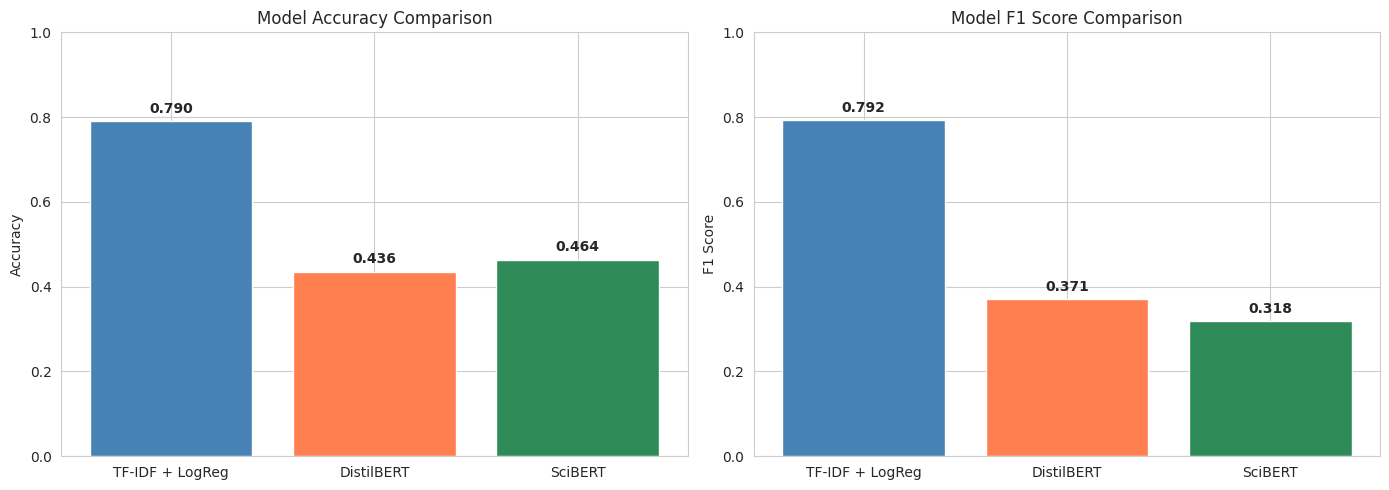

In [41]:
# Compare all models
print("=" * 50)
print("MODEL COMPARISON SUMMARY")
print("=" * 50)
print(f"\n{'Model':<30} {'Accuracy':<12} {'F1 Score':<12}")
print("-" * 54)
print(f"{'TF-IDF + Logistic Regression':<30} {accuracy:<12.4f} {f1_score:<12.4f}")
print(f"{'DistilBERT + ClassifierDL':<30} {bert_accuracy:<12.4f} {bert_f1:<12.4f}")
print(f"{'SciBERT + ClassifierDL':<30} {scibert_accuracy:<12.4f} {scibert_f1:<12.4f}")
print("=" * 54)

# Visualize comparison
models = ['TF-IDF + LogReg', 'DistilBERT', 'SciBERT']
accuracies = [accuracy, bert_accuracy, scibert_accuracy]
f1_scores = [f1_score, bert_f1, scibert_f1]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax[0].bar(models, accuracies, color=['steelblue', 'coral', 'seagreen'])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Model Accuracy Comparison')
ax[0].set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1 Score comparison
ax[1].bar(models, f1_scores, color=['steelblue', 'coral', 'seagreen'])
ax[1].set_ylabel('F1 Score')
ax[1].set_title('Model F1 Score Comparison')
ax[1].set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    ax[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()